In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset
import pandas as pd
import torch
from transformers import BertConfig, BertForSequenceClassification
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
import random
from tqdm.notebook import tqdm

seed_val = 0
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [3]:
dataset = pd.read_csv('preprocessed_data.csv')

In [4]:
from sklearn.model_selection import train_test_split
df_temp, df_test = train_test_split(dataset, test_size = 0.10, random_state = 0, stratify=dataset['class'])
df_train, df_val = train_test_split(df_temp, test_size = 0.10, random_state = 0, stratify=df_temp['class'])

In [5]:
#hyperparameters
hidden_dropout_prob = 0.3
num_labels = 3
learning_rate = 1e-5
weight_decay = 1e-2
batch_size = 32
epochs = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
df_train = df_train.drop(index = df_train[df_train.processed_tweet.isnull()].index, axis=0)
df_val = df_val.drop(index = df_val[df_val.processed_tweet.isnull()].index, axis=0)
df_test = df_test.drop(index = df_test[df_test.processed_tweet.isnull()].index, axis=0)

In [7]:
#Loading bert_base model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [8]:
#text embedding, including input_ids, token_type_ids and attention_mask
def tokenize(df):
    return tokenizer.batch_encode_plus(
    df.processed_tweet.tolist(),
    max_length = 40,
    padding='max_length', 
    truncation=True,
    return_token_type_ids=False
)

train_encoding = tokenize(df_train)
val_encoding = tokenize(df_val)

In [9]:
train_label = df_train['class'].values
val_label = df_val['class'].values

In [10]:
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encoding, train_label)
val_dataset = NewsDataset(val_encoding, val_label)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [12]:
#Define the Bert model
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_labels, hidden_dropout_prob=hidden_dropout_prob,output_attentions=False,
    output_hidden_states=False )
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
# Prepare optimizer, loss function and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

#optimizer = AdamW(model.parameters(), lr=learning_rate)
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-8)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader)*epochs
)

total_steps = len(train_dataloader) * 1

cross_entropy = nn.CrossEntropyLoss()

In [20]:
#helper functions
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, classification_report
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return balanced_accuracy_score(y_true=labels_flat, y_pred=preds_flat)  

def plot_confusion_matrix(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    cm = confusion_matrix(labels_flat, preds_flat)
    
    matrix_proportions = np.zeros((3,3))
    for i in range(0,3):
        matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
    names=['Hate','Offensive','Neither']
    confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
    ax = sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')

In [15]:
#Model training and validating
def train():
    model.train()
    total_train_loss = 0
    iter_num = 0
    total_iter = len(train_dataloader)
    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:
        # forward
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = cross_entropy(outputs[1], labels)
        total_train_loss += loss.item()
        
        # backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update parameter
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        iter_num += 1
        if(iter_num % 100==0):
            print("epoch: %d, iter_num: %d, loss: %.4f, %.2f%%" % (epoch, iter_num, loss.item(), iter_num/total_iter*100))
        
    print("Epoch: %d, Average training loss: %.4f"%(epoch, total_train_loss/len(train_dataloader)))
    

def validation():
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    predictions_val, true_vals = [], []

    for batch in val_dataloader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        logits = outputs[1]
        loss = cross_entropy(outputs[1], labels)

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        predictions_val.append(logits)
        true_vals.append(label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    predictions_val = np.concatenate(predictions_val, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    
    val_f1 = f1_score_func(predictions_val, true_vals)
    val_bacc = accuracy(predictions_val, true_vals)
    
    print("Accuracy: %.4f" % (avg_val_accuracy))
    print("Average testing loss: %.4f"%(total_eval_loss/len(val_dataloader)))
    print("F1 Score (Weighted): %.4f"%(val_f1))
    print("Balanced Accuracy Score: %.4f"%(val_bacc))
    print("-------------------------------")


In [16]:
for epoch in range(3):
    print("------------Epoch: %d ----------------" % epoch)
    train()
    validation()

------------Epoch: 0 ----------------
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 0:   0%|          | 0/628 [00:00<?, ?it/s]

epoch: 0, iter_num: 100, loss: 0.5666, 15.92%
epoch: 0, iter_num: 200, loss: 0.6207, 31.85%
epoch: 0, iter_num: 300, loss: 0.2678, 47.77%
epoch: 0, iter_num: 400, loss: 0.4239, 63.69%
epoch: 0, iter_num: 500, loss: 0.3001, 79.62%
epoch: 0, iter_num: 600, loss: 0.3232, 95.54%
Epoch: 0, Average training loss: 0.4216
Accuracy: 0.8978
Average testing loss: 0.3097
F1 Score (Weighted): 0.8863
Balanced Accuracy Score: 0.6657
-------------------------------
------------Epoch: 1 ----------------


Epoch 1:   0%|          | 0/628 [00:00<?, ?it/s]

epoch: 1, iter_num: 100, loss: 0.3198, 15.92%
epoch: 1, iter_num: 200, loss: 0.4011, 31.85%
epoch: 1, iter_num: 300, loss: 0.0939, 47.77%
epoch: 1, iter_num: 400, loss: 0.0824, 63.69%
epoch: 1, iter_num: 500, loss: 0.2161, 79.62%
epoch: 1, iter_num: 600, loss: 0.2494, 95.54%
Epoch: 1, Average training loss: 0.2853
Accuracy: 0.9043
Average testing loss: 0.2975
F1 Score (Weighted): 0.8958
Balanced Accuracy Score: 0.6922
-------------------------------
------------Epoch: 2 ----------------


Epoch 2:   0%|          | 0/628 [00:00<?, ?it/s]

epoch: 2, iter_num: 100, loss: 0.3967, 15.92%
epoch: 2, iter_num: 200, loss: 0.3437, 31.85%
epoch: 2, iter_num: 300, loss: 0.3613, 47.77%
epoch: 2, iter_num: 400, loss: 0.1877, 63.69%
epoch: 2, iter_num: 500, loss: 0.2304, 79.62%
epoch: 2, iter_num: 600, loss: 0.4129, 95.54%
Epoch: 2, Average training loss: 0.2593
Accuracy: 0.9110
Average testing loss: 0.2820
F1 Score (Weighted): 0.9073
Balanced Accuracy Score: 0.7391
-------------------------------


In [17]:
#Implement the fine-tuned model on testset
test_encoding = tokenize(df_test)
test_label = df_test['class'].values
test_dataset = NewsDataset(test_encoding, test_label)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

def test():
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    predictions_test, true_test = [], []

    for batch in test_dataloader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        logits = outputs[1]
        loss = cross_entropy(outputs[1], labels)

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        predictions_test.append(logits)
        true_test.append(label_ids)
        
    avg_test_accuracy = total_eval_accuracy / len(test_dataloader)
    predictions_test = np.concatenate(predictions_test, axis=0)
    true_test = np.concatenate(true_test, axis=0)
    
    test_f1 = f1_score_func(predictions_test, true_test)
    test_bacc = accuracy(predictions_test, true_test)
    
    print("Accuracy: %.4f" % (avg_test_accuracy))
    print("Average testing loss: %.4f"%(total_eval_loss/len(test_dataloader)))
    print("F1 Score (Weighted): %.4f"%(test_f1))
    print("Balanced Accuracy Score: %.4f"%(test_bacc))
    print("-------------------------------")
    
    return avg_test_accuracy, predictions_test, true_test

In [18]:
avg_test_accuracy, predictions_test, true_test = test()

Accuracy: 0.9013
Average testing loss: 0.2779
F1 Score (Weighted): 0.8956
Balanced Accuracy Score: 0.6957
-------------------------------


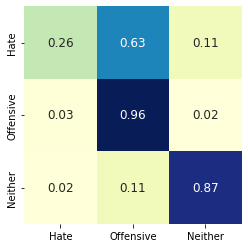

In [21]:
plot_confusion_matrix(predictions_test,true_test)